<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/colab_tianchi_baseline_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp /content/drive/MyDrive/suichang_round1_test_partA_210120.zip  /content/

In [2]:
!cp /content/drive/MyDrive/suichang_round1_train_210120.zip /content/

In [ ]:
!unzip  /content/suichang_round1_test_partA_210120.zip

In [ ]:
!unzip /content/suichang_round1_train_210120.zip

In [5]:
! nvidia-smi

Sat Feb  6 06:54:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import cv2.cv2 as cv
import cv2
import os
import shutil

images_dir='/content/suichang_round1_train_210120/'
save_imgs='/content/images'
save_masks='/content/masks_new'
if not os.path.exists(save_imgs):os.makedirs(save_imgs)
if not os.path.exists(save_masks):os.makedirs(save_masks)
tif_list = [x for x in os.listdir(images_dir)]   # 获取目录中所有tif格式图像列表
for num,name in enumerate(tif_list):      # 遍历列表
    if name.endswith(".tif"):
        img = cv.imread(os.path.join(images_dir, name),-1)       #  读取列表中的tif图像
        cv.imwrite(os.path.join(save_imgs,name.split('.')[0]+".jpg"),img)    # tif 格式转 jpg 
    else:
        img =cv.imread(os.path.join(images_dir, name),cv2.IMREAD_GRAYSCALE)
        img=img-1
        cv2.imwrite(os.path.join(save_masks, name),img)
        #shutil.copy(os.path.join(images_dir, name),os.path.join(save_masks,name))
save_test='/content/suichang_round1_test_partA_210120/'
save_test_dir='/content/test_jpg'
if not os.path.exists(save_test_dir):os.makedirs(save_test_dir)
for name in os.listdir(save_test):
    img = cv.imread(os.path.join(save_test, name),-1)       # 
    cv.imwrite(os.path.join(save_test_dir,name.split('.')[0]+".jpg"),img)    # tif 格式转 jpg 

In [7]:
import os
import shutil
from tqdm import tqdm
images_dir='/content/images/'
mask_dir='/content/masks_new'
ann_dir_train='/content/satellite_jpg/ann_dir/train/'
ann_dir_val='/content/satellite_jpg/ann_dir/val/'
ann_dir_train_val='/content/satellite_jpg/ann_dir/train_val/'
img_dir_train='/content/satellite_jpg/img_dir/train/'
img_dir_val='/content/satellite_jpg/img_dir/val/'
img_dir_train_val='/content/satellite_jpg/img_dir/train_val/'

if not os.path.exists(ann_dir_train):os.makedirs(ann_dir_train)
if not os.path.exists(ann_dir_val):os.makedirs(ann_dir_val)
if not os.path.exists(ann_dir_train_val):os.makedirs(ann_dir_train_val)
if not os.path.exists(img_dir_train):os.makedirs(img_dir_train)
if not os.path.exists(img_dir_val):os.makedirs(img_dir_val)
if not os.path.exists(img_dir_train_val):os.makedirs(img_dir_train_val)
val_ratio=0.2
val_interval=int((1/val_ratio))
train_size=0
val_size=0
names=os.listdir(images_dir)
for i in tqdm(range(len(names))):
    name=names[i]
    mask_name=name[:-4]+'.png'
    if i%val_interval==0:
        shutil.copy(os.path.join(images_dir,name),os.path.join(img_dir_val,name))
        shutil.copy(os.path.join(mask_dir,mask_name), os.path.join(ann_dir_val, mask_name))
        val_size+=1
    else:
        shutil.copy(os.path.join(images_dir, name), os.path.join(img_dir_train, name))
        shutil.copy(os.path.join(mask_dir,mask_name), os.path.join(ann_dir_train, mask_name))
        train_size+=1
    shutil.copy(os.path.join(images_dir, name), os.path.join(img_dir_train_val, name))
    shutil.copy(os.path.join(mask_dir, mask_name), os.path.join(ann_dir_train_val, mask_name))
print("train size:{},val size:{}".format(train_size,val_size))

100%|██████████| 16017/16017 [00:07<00:00, 2259.88it/s]

train size:12813,val size:3204


In [ ]:
! pip install albumentations==0.4.6

In [ ]:
!pip install pytorch_toolbelt

In [ ]:
! pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [11]:
import os
import cv2
import time
import copy
import torch
import random
import logging
import numpy as np
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from tqdm import tqdm
from glob import glob
from torch.utils.data import Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# from .transform import train_transform
# from .transform import val_transform

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    # reszie
    A.Resize(256, 256),
    # 
    A.OneOf([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5)
    ]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

class RSCDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, transform=None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.ids = [os.path.splitext(file)[0] for file in os.listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img):
        img_nd = np.array(pil_img)
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
        try:
            img_trans = img_nd.transpose(2, 0, 1)
        except:
            print(img_nd.shape)
        if img_trans.max() > 1: img_trans = img_trans / 255
        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        img_file = glob(self.imgs_dir + idx + '.*')
        mask_file = glob(self.masks_dir + idx + '.*')

        image = cv2.imread(img_file[0], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file[0], cv2.IMREAD_GRAYSCALE)

        #if self.transform:
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

        return {
            'image': image,
            'label': mask.long()
        }



# if __name__ == '__main__':
#     data_dir = "/content/satellite_jpg"
#     train_imgs_dir = os.path.join(data_dir, "img_dir/train/")
#     train_labels_dir = os.path.join(data_dir, "ann_dir/train/")

#     train_data = RSCDataset(train_imgs_dir, train_labels_dir, transform=train_transform)
#     train_data[500]

In [12]:
import os
import time
import logging

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def second2time(second):
    if second < 60:
        return str('{}'.format(round(second, 4)))
    elif second < 60*60:
        m = second//60
        s = second % 60
        return str('{}:{}'.format(int(m), round(s, 1)))
    elif second < 60*60*60:
        h = second//(60*60)
        m = second % (60*60)//60
        s = second % (60*60) % 60
        return str('{}:{}:{}'.format(int(h), int(m), int(s)))

def inial_logger(file):
    logger = logging.getLogger('log')
    logger.setLevel(level=logging.DEBUG)

    formatter = logging.Formatter('%(message)s')

    file_handler = logging.FileHandler(file)
    file_handler.setLevel(level=logging.INFO)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    stream_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)

    return logger

In [13]:
import sys
import os
import numpy as np

def unique(ar, return_index=False, return_inverse=False, return_counts=False):
    ar = np.asanyarray(ar).flatten()

    optional_indices = return_index or return_inverse
    optional_returns = optional_indices or return_counts

    if ar.size == 0:
        if not optional_returns:
            ret = ar
        else:
            ret = (ar,)
            if return_index:
                ret += (np.empty(0, np.bool),)
            if return_inverse:
                ret += (np.empty(0, np.bool),)
            if return_counts:
                ret += (np.empty(0, np.intp),)
        return ret
    if optional_indices:
        perm = ar.argsort(kind='mergesort' if return_index else 'quicksort')
        aux = ar[perm]
    else:
        ar.sort()
        aux = ar
    flag = np.concatenate(([True], aux[1:] != aux[:-1]))

    if not optional_returns:
        ret = aux[flag]
    else:
        ret = (aux[flag],)
        if return_index:
            ret += (perm[flag],)
        if return_inverse:
            iflag = np.cumsum(flag) - 1
            inv_idx = np.empty(ar.shape, dtype=np.intp)
            inv_idx[perm] = iflag
            ret += (inv_idx,)
        if return_counts:
            idx = np.concatenate(np.nonzero(flag) + ([ar.size],))
            ret += (np.diff(idx),)
    return ret
def colorEncode(labelmap, colors, mode='RGB'):
    labelmap = labelmap.astype('int')
    labelmap_rgb = np.zeros((labelmap.shape[0], labelmap.shape[1], 3),
                            dtype=np.uint8)
    for label in unique(labelmap):
        if label < 0:
            continue
        labelmap_rgb += (labelmap == label)[:, :, np.newaxis] * \
            np.tile(colors[label],
                    (labelmap.shape[0], labelmap.shape[1], 1))

    if mode == 'BGR':
        return labelmap_rgb[:, :, ::-1]
    else:
        return labelmap_rgb
#

In [14]:
import numpy as np
class IOUMetric:
    """
    Class to calculate mean-iou using fast_hist method
    """

    def __init__(self, num_classes=10):
        self.num_classes = num_classes
        self.hist = np.zeros((num_classes, num_classes))

    def _fast_hist(self, label_pred, label_true):
        mask = (label_true >= 0) & (label_true < self.num_classes)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) +
            label_pred[mask], minlength=self.num_classes ** 2).reshape(self.num_classes, self.num_classes)
        return hist

    def add_batch(self, predictions, gts):
        for lp, lt in zip(predictions, gts):
            self.hist += self._fast_hist(lp.flatten(), lt.flatten())

    def evaluate(self):
        acc = np.diag(self.hist).sum() / self.hist.sum()
        acc_cls = np.diag(self.hist) / self.hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(self.hist) / (self.hist.sum(axis=1) + self.hist.sum(axis=0) - np.diag(self.hist))
        mean_iu = np.nanmean(iu)
        freq = self.hist.sum(axis=1) / self.hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        return acc, acc_cls, iu, mean_iu, fwavacc

In [15]:
import os
import time
import copy
import torch
import random
import logging
import numpy as np
import torch.nn as nn
import torch.optim as optim

from glob import glob
from PIL import Image
from tqdm import tqdm

from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pytorch_toolbelt import losses as L
# from utils.utils import AverageMeter, second2time, inial_logger
from albumentations.augmentations import functional as F
#from .metric import IOUMetric
from torch.cuda.amp import autocast, GradScaler#need pytorch>1.6
from segmentation_models_pytorch.losses import DiceLoss,FocalLoss,SoftCrossEntropyLoss
#from segmentation_models_pytorch import *
Image.MAX_IMAGE_PIXELS = 1000000000000000
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

def smooth(v, w=0.85):
    last = v[0]
    smoothed = []
    for point in v:
        smoothed_val = last * w + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

def train_net(param, model, train_data, valid_data, plot=False,device='cuda'):
    # 初始化参数
    model_name      = param['model_name']
    epochs          = param['epochs']
    batch_size      = param['batch_size']
    lr              = param['lr']
    gamma           = param['gamma']
    step_size       = param['step_size']
    momentum        = param['momentum']
    weight_decay    = param['weight_decay']

    disp_inter      = param['disp_inter']
    save_inter      = param['save_inter']
    min_inter       = param['min_inter']
    iter_inter      = param['iter_inter']

    save_log_dir    = param['save_log_dir']
    save_ckpt_dir   = param['save_ckpt_dir']
    load_ckpt_dir   = param['load_ckpt_dir']

    #
    scaler = GradScaler() 

    # 网络参数
    train_data_size = train_data.__len__()
    valid_data_size = valid_data.__len__()
    c, y, x = train_data.__getitem__(0)['image'].shape
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=1)
    valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False, num_workers=1)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4 ,weight_decay=weight_decay)
    #optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=momentum, weight_decay=weight_decay)
    #scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=1e-5, last_epoch=-1)
    #criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
    DiceLoss_fn=DiceLoss(mode='multiclass')
    SoftCrossEntropy_fn=SoftCrossEntropyLoss(smooth_factor=0.1)
    criterion = L.JointLoss(first=DiceLoss_fn, second=SoftCrossEntropy_fn,
                              first_weight=0.5, second_weight=0.5).cuda()
    logger = inial_logger(os.path.join(save_log_dir, time.strftime("%m-%d %H:%M:%S", time.localtime()) +'_'+model_name+ '.log'))

    # 主循环
    train_loss_total_epochs, valid_loss_total_epochs, epoch_lr = [], [], []
    train_loader_size = train_loader.__len__()
    valid_loader_size = valid_loader.__len__()
    best_iou = 0
    best_epoch=0
    best_mode = copy.deepcopy(model)
    epoch_start = 0
    if load_ckpt_dir is not None:
        ckpt = torch.load(load_ckpt_dir)
        epoch_start = ckpt['epoch']
        model.load_state_dict(ckpt['state_dict'])
        optimizer.load_state_dict(ckpt['optimizer'])

    logger.info('Total Epoch:{} Image_size:({}, {}) Training num:{}  Validation num:{}'.format(epochs, x, y, train_data_size, valid_data_size))
    #
    for epoch in range(epoch_start, epochs):
        epoch_start = time.time()
        # 训练阶段
        model.train()
        train_epoch_loss = AverageMeter()
        train_iter_loss = AverageMeter()
        for batch_idx, batch_samples in enumerate(train_loader):
            data, target = batch_samples['image'], batch_samples['label']
            data, target = Variable(data.to(device)), Variable(target.to(device))
            with autocast(): #need pytorch>1.6
                pred = model(data)
                loss = criterion(pred, target)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            scheduler.step(epoch + batch_idx / train_loader_size) 
            image_loss = loss.item()
            train_epoch_loss.update(image_loss)
            train_iter_loss.update(image_loss)
            if batch_idx % iter_inter == 0:
                spend_time = time.time() - epoch_start
                logger.info('[train] epoch:{} iter:{}/{} {:.2f}% lr:{:.6f} loss:{:.6f} ETA:{}min'.format(
                    epoch, batch_idx, train_loader_size, batch_idx/train_loader_size*100,
                    optimizer.param_groups[-1]['lr'],
                    train_iter_loss.avg,spend_time / (batch_idx+1) * train_loader_size // 60 - spend_time // 60))
                train_iter_loss.reset()

        # 验证阶段
        model.eval()
        valid_epoch_loss = AverageMeter()
        valid_iter_loss = AverageMeter()
        iou=IOUMetric(10)
        with torch.no_grad():
            for batch_idx, batch_samples in enumerate(valid_loader):
                data, target = batch_samples['image'], batch_samples['label']
                data, target = Variable(data.to(device)), Variable(target.to(device))
                pred = model(data)
                loss = criterion(pred, target)
                pred=pred.cpu().data.numpy()
                pred= np.argmax(pred,axis=1)
                iou.add_batch(pred,target.cpu().data.numpy())
                #
                image_loss = loss.item()
                valid_epoch_loss.update(image_loss)
                valid_iter_loss.update(image_loss)
                # if batch_idx % iter_inter == 0:
                #     logger.info('[val] epoch:{} iter:{}/{} {:.2f}% loss:{:.6f}'.format(
                #         epoch, batch_idx, valid_loader_size, batch_idx / valid_loader_size * 100, valid_iter_loss.avg))
            val_loss=valid_iter_loss.avg
            acc, acc_cls, iu, mean_iu, fwavacc=iou.evaluate()
            logger.info('[val] epoch:{} miou:{:.2f}'.format(epoch,mean_iu))
                

        # 保存loss、lr
        train_loss_total_epochs.append(train_epoch_loss.avg)
        valid_loss_total_epochs.append(valid_epoch_loss.avg)
        epoch_lr.append(optimizer.param_groups[0]['lr'])
        # 保存模型
        if epoch % save_inter == 0 and epoch > min_inter:
            state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            filename = os.path.join(save_ckpt_dir, 'checkpoint-epoch{}.pth'.format(epoch))
            torch.save(state, filename)  # pytorch1.6会压缩模型，低版本无法加载
        # 保存最优模型
        if mean_iu > best_iou:  # train_loss_per_epoch valid_loss_per_epoch
            state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            filename = os.path.join(save_ckpt_dir, 'checkpoint-best.pth')
            torch.save(state, filename)
            best_iou = mean_iu
            best_mode = copy.deepcopy(model)
            logger.info('[save] Best Model saved at epoch:{} ============================='.format(epoch))
        #scheduler.step()
        # 显示loss
    # 训练loss曲线
    if plot:
        x = [i for i in range(epochs)]
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x, smooth(train_loss_total_epochs, 0.6), label='train loss')
        ax.plot(x, smooth(valid_loss_total_epochs, 0.6), label='val loss')
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_ylabel('CrossEntropy', fontsize=15)
        ax.set_title('train curve', fontsize=15)
        ax.grid(True)
        plt.legend(loc='upper right', fontsize=15)
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x, epoch_lr,  label='Learning Rate')
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_ylabel('Learning Rate', fontsize=15)
        ax.set_title('lr curve', fontsize=15)
        ax.grid(True)
        plt.legend(loc='upper right', fontsize=15)
        plt.show()
            
    return best_mode, model

In [16]:
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
#from utils import train_net
#from dataset import RSCDataset
#from dataset import train_transform, val_transform
from torch.cuda.amp import autocast
#
import segmentation_models_pytorch as smp
Image.MAX_IMAGE_PIXELS = 1000000000000000

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda")

# 准备数据集
data_dir = "/content/satellite_jpg/"
train_imgs_dir = os.path.join(data_dir, "img_dir/train_val/")
val_imgs_dir = os.path.join(data_dir, "img_dir/val/")

train_labels_dir = os.path.join(data_dir, "ann_dir/train_val/")
val_labels_dir = os.path.join(data_dir, "ann_dir/val/")

train_data = RSCDataset(train_imgs_dir, train_labels_dir, transform=train_transform)
valid_data = RSCDataset(val_imgs_dir, val_labels_dir, transform=val_transform)

# 网络

class seg_qyl(nn.Module):
    def __init__(self, model_name, n_class):
        super().__init__()  
        self.model = smp.UnetPlusPlus(# UnetPlusPlus 
                encoder_name=model_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pretrained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
                classes=n_class,                      # model output channels (number of classes in your dataset)
            )
    @autocast()
    def forward(self, x):
        #with autocast():
        x = self.model(x)
        return x
#
model_name = 'efficientnet-b6'#xception
n_class=10
model=seg_qyl(model_name,n_class).cuda()
model= torch.nn.DataParallel(model)
checkpoints=torch.load('/content/drive/MyDrive/tianchi/outputs/efficientnet-b6/ckpt/checkpoint-best.pth')
model.load_state_dict(checkpoints['state_dict'])
# 模型保存路径
save_ckpt_dir = os.path.join('/content/drive/MyDrive/tianchi/outputs/', model_name, 'ckpt')
save_log_dir = os.path.join('/content/drive/MyDrive/tianchi/outputs/', model_name)
if not os.path.exists(save_ckpt_dir):
    os.makedirs(save_ckpt_dir)
if not os.path.exists(save_log_dir):
    os.makedirs(save_log_dir)

# 参数设置
param = {}

param['epochs'] = 40          # 训练轮数
param['batch_size'] = 16       # 批大小
param['lr'] = 1e-2            # 学习率
param['gamma'] = 0.2          # 学习率衰减系数
param['step_size'] = 5        # 学习率衰减间隔
param['momentum'] = 0.9       # 动量
param['weight_decay'] = 5e-4    # 权重衰减
param['disp_inter'] = 1       # 显示间隔(epoch)
param['save_inter'] = 4       # 保存间隔(epoch)
param['iter_inter'] = 50     # 显示迭代间隔(batch)
param['min_inter'] = 10

param['model_name'] = model_name          # 模型名称
param['save_log_dir'] = save_log_dir      # 日志保存路径
param['save_ckpt_dir'] = save_ckpt_dir    # 权重保存路径

# 加载权重路径（继续训练）
param['load_ckpt_dir'] = None

#
# 训练
best_model, model = train_net(param, model, train_data, valid_data)

[train] epoch:21 iter:150/1002 14.97% lr:0.000300 loss:0.586034 ETA:12.0min
INFO:log:[train] epoch:21 iter:150/1002 14.97% lr:0.000300 loss:0.586034 ETA:12.0min
[train] epoch:21 iter:200/1002 19.96% lr:0.000300 loss:0.581356 ETA:12.0min
INFO:log:[train] epoch:21 iter:200/1002 19.96% lr:0.000300 loss:0.581356 ETA:12.0min
[train] epoch:21 iter:250/1002 24.95% lr:0.000300 loss:0.580643 ETA:11.0min
INFO:log:[train] epoch:21 iter:250/1002 24.95% lr:0.000300 loss:0.580643 ETA:11.0min
[train] epoch:21 iter:300/1002 29.94% lr:0.000300 loss:0.587660 ETA:10.0min
INFO:log:[train] epoch:21 iter:300/1002 29.94% lr:0.000300 loss:0.587660 ETA:10.0min
[train] epoch:21 iter:350/1002 34.93% lr:0.000300 loss:0.590600 ETA:9.0min
INFO:log:[train] epoch:21 iter:350/1002 34.93% lr:0.000300 loss:0.590600 ETA:9.0min
[train] epoch:21 iter:400/1002 39.92% lr:0.000300 loss:0.598005 ETA:9.0min
INFO:log:[train] epoch:21 iter:400/1002 39.92% lr:0.000300 loss:0.598005 ETA:9.0min
[train] epoch:21 iter:450/1002 44.91% 

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-8cbb526bae3e>", line 84, in <module>
    best_model, model = train_net(param, model, train_data, valid_data)
  File "<ipython-input-15-abe9f80b32a3>", line 110, in train_net
    scaler.scale(loss).backward()
  File "/usr/local/lib/python3.6/dist-packages/torch/tensor.py", line 221, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py", line 132, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_trac

KeyboardInterrupt: ignored

In [18]:
def unique(ar, return_index=False, return_inverse=False, return_counts=False):
    ar = np.asanyarray(ar).flatten()

    optional_indices = return_index or return_inverse
    optional_returns = optional_indices or return_counts

    if ar.size == 0:
        if not optional_returns:
            ret = ar
        else:
            ret = (ar,)
            if return_index:
                ret += (np.empty(0, np.bool),)
            if return_inverse:
                ret += (np.empty(0, np.bool),)
            if return_counts:
                ret += (np.empty(0, np.intp),)
        return ret
    if optional_indices:
        perm = ar.argsort(kind='mergesort' if return_index else 'quicksort')
        aux = ar[perm]
    else:
        ar.sort()
        aux = ar
    flag = np.concatenate(([True], aux[1:] != aux[:-1]))

    if not optional_returns:
        ret = aux[flag]
    else:
        ret = (aux[flag],)
        if return_index:
            ret += (perm[flag],)
        if return_inverse:
            iflag = np.cumsum(flag) - 1
            inv_idx = np.empty(ar.shape, dtype=np.intp)
            inv_idx[perm] = iflag
            ret += (inv_idx,)
        if return_counts:
            idx = np.concatenate(np.nonzero(flag) + ([ar.size],))
            ret += (np.diff(idx),)
    return ret

def colorEncode(labelmap, colors, mode='RGB'):
    labelmap = labelmap.astype('int')
    labelmap_rgb = np.zeros((labelmap.shape[0], labelmap.shape[1], 3),
                            dtype=np.uint8)
    for label in unique(labelmap):
        if label < 0:
            continue
        labelmap_rgb += (labelmap == label)[:, :, np.newaxis] * \
            np.tile(colors[label],
                    (labelmap.shape[0], labelmap.shape[1], 1))

    if mode == 'BGR':
        return labelmap_rgb[:, :, ::-1]
    else:
        return labelmap_rgb



In [35]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2
import time
from io import BytesIO
import base64
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000000000
from tqdm import tqdm
import glob
import os
from scipy.io import loadmat
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
#from utils import colorEncode
import torch.nn as nn
from torch.cuda.amp import autocast
def visualize_result(img_dir, pred):
    #
    img=cv2.imread(img_dir)
    colors = loadmat('/content/color150.mat')['colors']
    names = {
            1: "耕地",
            2: "林地",
            3: "草地",
            4: "道路",
            5: "城镇建设用地",
            6: "农村建设用地",
            7: "工业用地",
            8: "构筑物",
            9: "水域",
            10: "裸地"
        }
    # print predictions in descending order
    pred = np.int32(pred)
    pixs = pred.size
    uniques, counts = np.unique(pred, return_counts=True)
    #
    for idx in np.argsort(counts)[::-1]:
        name = names[uniques[idx] + 1]
        ratio = counts[idx] / pixs * 100
        if ratio > 0.1:
            print("  {}: {:.2f}%".format(name, ratio))

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    #print(pred_color.shape)
    #pred_color=cv2.resize(pred_color,(256,256))
    im_vis = np.concatenate((img, pred_color), axis=1)

    #
    #img_name=image_demo_dir.split('/')[-1]
    save_dir,name=os.path.split(img_dir)
    Image.fromarray(im_vis).save('256x256.png')
def get_infer_transform():
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    return transform
#
def inference(img_dir):
    transform=get_infer_transform()
    image = cv2.imread(img_dir, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = transform(image=image)['image']
    img=img.unsqueeze(0)
    #print(img.shape)
    with torch.no_grad():
        img=img.cuda()
        output = model(img)
    #
    pred = output.squeeze().cpu().data.numpy()
    pred = np.argmax(pred,axis=0)
    return pred+1

class seg_qyl(nn.Module):
    def __init__(self, model_name, n_class):
        super().__init__()
        self.model = smp.UnetPlusPlus(
                encoder_name=model_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pretrained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
                classes=n_class,                      # model output channels (number of classes in your dataset)
            )
    #
    @autocast()
    def forward(self, x):
        #with autocast():
        x = self.model(x)
        return x
#
if __name__=="__main__":
    model_name = 'efficientnet-b6'#efficientnet-b4
    n_class=10
    model=seg_qyl(model_name,n_class).cuda()
    model= torch.nn.DataParallel(model)
    checkpoints=torch.load('/content/drive/MyDrive/tianchi/outputs/efficientnet-b6/ckpt/checkpoint-epoch32.pth')
    model.load_state_dict(checkpoints['state_dict'])
    model.eval()
    use_demo=True
    assert_list=[1,2,3,4,5,6,7,8,9,10]
    if use_demo:
        img_dir='/content/test_jpg/000003.jpg'
        pred=inference(img_dir)
        infer_start_time = time.time()
        visualize_result(img_dir, pred)
        #
    else:
        out_dir='/content/drive/MyDrive/tianchi/results/'
        if not os.path.exists(out_dir):os.makedirs(out_dir)
        test_paths=glob.glob('/content/test_jpg/*')
        for per_path in tqdm(test_paths):
            result=inference(per_path)
            img=Image.fromarray(np.uint8(result))
            img=img.convert('L')
            #print(out_path)
            out_path=os.path.join(out_dir,per_path.split('/')[-1][:-4]+'.png')
            img.save(out_path)

  林地: 84.03%
  草地: 13.60%
  城镇建设用地: 1.59%
  裸地: 0.79%


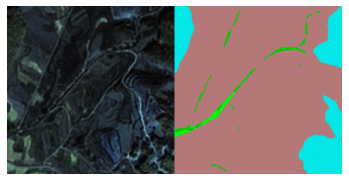

In [36]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
result = mpimg.imread('/content/256x256.png')
plt.imshow(result) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


In [ ]:
!zip -r results.zip /content/drive/MyDrive/tianchi/results